# A Bayesian Test for Cointegration

## R notebook implementation

The code in this notebook is adapted from the original MATLAB implementation by Chris Bracegirdle for the paper [*Bayesian Conditional Cointegration*](http://icml.cc/2012/papers/570.pdf) presented at [*ICML 2012*](http://icml.cc/2012/)

<a class="typeform-share button" href="https://bayesiancointegration.typeform.com/to/gRS0pq" data-mode="popup" style="display:inline-block;text-decoration:none;background-color:#267DDD;color:white;cursor:pointer;font-family:Helvetica,Arial,sans-serif;font-size:20px;line-height:50px;text-align:center;margin:0;height:50px;padding:0px 33px;border-radius:25px;max-width:100%;white-space:nowrap;overflow:hidden;text-overflow:ellipsis;font-weight:bold;-webkit-font-smoothing:antialiased;-moz-osx-font-smoothing:grayscale;" target="_blank">Contact me</a><script>(function(){var qs,js,q,s,d=document,gi=d.getElementById,ce=d.createElement,gt=d.getElementsByTagName,id="typef_orm_share",b="https://s3-eu-west-1.amazonaws.com/share.typeform.com/";if(!gi.call(d,id)){js=ce.call(d,"script");js.id=id;js.src=b+"share.js";q=gt.call(d,"script")[0];q.parentNode.insertBefore(js,q)}})()</script>

In [1]:
install.packages(c("tseries","pROC"))
options(repr.plot.width=4, repr.plot.height=4)

cat("

Bayesian Cointegration 
Implementation of a Bayesian test for cointegration

Written by Chris Bracegirdle
(c) Chris Bracegirdle 2015. All rights reserved.")


The downloaded binary packages are in
	/var/folders/bc/dnbc_47x6j7036ft8dp3bckh0000gn/T//Rtmp9bibIM/downloaded_packages


Bayesian Cointegration 
Implementation of a Bayesian test for cointegration

Written by Chris Bracegirdle
(c) Chris Bracegirdle 2015. All rights reserved.

This is a rather contrived function to randomly generate two time series, x and y, after making a random decision as to whether they are cointegrated, and generating according to the corresponding generating function

In [2]:
GenerateData <- function(T) {
    cointegrated <- runif(1) > 0.5
    phi <- if(cointegrated) runif(1) * 2 - 1 else 1

    std_eta <- exp(rnorm(1))
    std_x <- exp(rnorm(1))
    intercept <- exp(rnorm(1, sd=5))
    slope <- exp(rnorm(1, mean=1, sd=5))

    epsilon <- double(length=T)
    x <- double(length=T)
    y <- double(length=T)
    epsilon[1] <- rnorm(1, sd=std_eta)
    x[1] <- rnorm(1, sd=std_x)
    y[1] <- intercept + slope * x[1] + epsilon[1]
    for (t in 2:T){
        epsilon[t] <- phi * epsilon[t-1] + rnorm(1, sd=std_eta)
        x[t] <- x[t-1] + rnorm(1, sd=std_x)
        y[t] <- intercept + slope * x[t] + epsilon[t]
    }
    return(list("cointegrated" = cointegrated, "x" = x, "y" = y))
}

And here's what some randomly-generated data look like. Give it a whirl!

$cointegrated
[1] FALSE

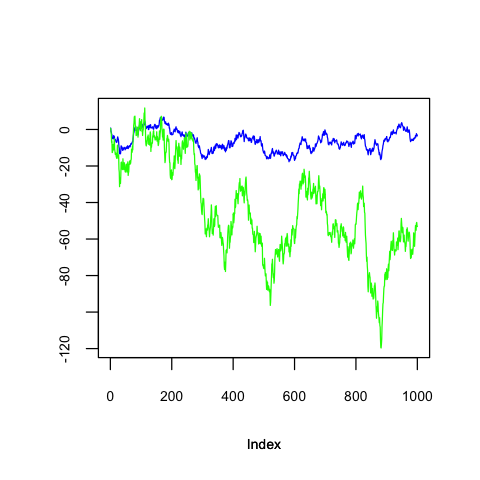

In [3]:
gendata = GenerateData(1000)
par(cex.axis=0.7, cex.lab=0.7, cex.main=0.7, cex.sub=0.7)
plot(gendata$x, type='l', col='blue', ylim=range(gendata$x, gendata$y), ylab='')
par(new=T); plot(gendata$y, type='l', col='green', axes=F, ylab=''); par(new=F)
gendata[names(gendata)=='cointegrated']

In [4]:
LinearRegression <- function(x,y) {
    slope <- cor(x, y) * (sd(y) / sd(x))
    intercept <- mean(y) - (slope * mean(x))
    std_eta = sd( y - intercept - slope * x)
    return(list("slope"=slope, "intercept"=intercept, "std_eta"=std_eta))
}

In [5]:
LinearRegression(gendata$x,gendata$y)

$slope
[1] 3.078973

$intercept
[1] -24.11988

$std_eta
[1] 21.30093

This is an implementation of logSumExp with support for a vector of indices (b)

In [6]:
mylogsumexp <- function(a,b) {
    #LOGSUMEXP Compute log(sum(exp(a).*b)) valid for large a
    # example: mylogsumexp(c(-1000,-1001,-998),c(1,2,0.5))
    amax <- max(Re(a))
    if (amax == -Inf) {
        amax=0
    }
    return(amax + log(as.complex(sum(exp(a-amax)*b))))
}

This is a key result from the paper: calculating the moments and area as derived in the paper

In [7]:
CalcLogAreaLog <- function(logf,logF) {
    lncdf <- pnorm(c(1, -1), mean = Re(exp(logf)), sd = Re(exp(0.5*logF)), log.p = TRUE)
    logarea <- Re(mylogsumexp(lncdf, c(1, -1))-log(2))
    return(logarea)
}
CalcMomentsLog <- function(logf,logF,logarea) {
    lnpdf <- dnorm(c(1,-1), mean = Re(exp(logf)), sd = Re(exp(0.5*logF)), log = TRUE)
    logmoment1 <- mylogsumexp(c(lnpdf[1]+logF-logarea, lnpdf[2]+logF-logarea, logf), c(-0.5, 0.5, 1))
    logmoment2 <- mylogsumexp(c(logF+logf+lnpdf[1]-logarea, logF+logf+lnpdf[2]-logarea, 
                                logF+lnpdf[1]-logarea, logF+lnpdf[2]-logarea, 2*logf, logF),
                              c(-0.5, 0.5, 
                                -0.5, -0.5, 1, 1))
    return(list("moment1"=Re(exp(logmoment1)), "moment2"=Re(exp(logmoment2))))
}

Now inference: filtering and the EM update routine.

In [8]:
Filtering <- function(V,std_eta) {
    T <- length(V)
        
    # DIRECT METHOD
    logft <- log(as.complex(sum(V[2:T]*V[1:T-1])))-log(sum(V[1:T-1]^2))
    logFt <- 2*log(std_eta) - log(sum(V[1:T-1]^2))
    stopifnot(!is.nan(logft)) #logft must be real
    stopifnot(!is.nan(logFt)) #logFt must be real
    stopifnot(is.double(logFt)) #logFt must be real
    logarea <- CalcLogAreaLog(logft,logFt)
    loglik <- -0.5*log(sum(V[1:T-1]^2))-0.5*(T-2)*log(2*pi*std_eta^2)+logarea
                        -(sum(V[2:T]^2)-sum(V[2:T]*V[1:T-1])^2/sum(V[1:T-1]^2))/(2*std_eta^2)

    # calculate moments
    moments <- CalcMomentsLog(logft,logFt,logarea)
    
    return(list("loglik"=loglik, "moment1"=moments$moment1, "moment2"=moments$moment2))
}

EMUpdate <- function(x,y,moment1,moment2) {
    T <- length(x)
    xt <- x[2:T]
    xtm1 <- x[1:T-1]
    yt <- y[2:T]
    ytm1 <- y[1:T-1]
    
    # find the coefficients
    a <- 2 * (T-1) * moment1 - (T-1) * moment2 - (T-1)
    b <- moment1 * sum(xt+xtm1) - moment2 * sum(xtm1) - sum(xt)
    c <- moment2 * sum(ytm1) - moment1 * sum(yt + ytm1) + sum(yt)
    d <- 2 * moment1 * sum(xt * xtm1) - moment2 * sum(xtm1 ^ 2) - sum(xt ^ 2)
    e <- moment2 * sum(xtm1 * ytm1) - moment1 * sum(xtm1 * yt + xt * ytm1) + sum(xt * yt)
        
    # solve simultaneous equations
    slope <- ((a * e) - (c * b)) / ((b ^ 2) - (a * d))
    intercept <- (-slope * d / b) - (e / b)

    # now find optimal sigma
    eps <- y - intercept - slope * x
    ept <- eps[2:T]
    eptm1 <- eps[1:T-1]
    std_eta <- sqrt( (sum(ept^2) - 2 * moment1 * sum( ept * eptm1)  + moment2 * sum(eptm1 ^ 2)) / (T-1) )

    stopifnot(std_eta>0) #Standard deviation must be positive
    stopifnot(is.double(std_eta)) #Standard deviation must be real
    return(list("slope"=slope,"intercept"=intercept,"std_eta"=std_eta))
}

This is the real meat of the routine, simple since the inference routines are given above.

In [9]:
CointInference <- function(epsilon,std_eta,x,y) {
    filtering <- Filtering(epsilon,std_eta)
    update <- EMUpdate(x,y,filtering$moment1,filtering$moment2)
    #std_eta_with_old_regression <- sqrt( (sum(epsilon[1:]**2) \
    #                                      - 2 * sum(moment1 * epsilon[1:] * epsilon[:-1]) \
    #                                      + sum(moment2 * epsilon[:-1] ** 2)) / (x.size - 1) )
    return(list("loglik"=filtering$loglik,
                "slope"=update$slope, "intercept"=update$intercept,
                "std_eta"=update$std_eta#,"std_eta_with_old_regression"=std_eta_with_old_regression
                                        #,"moment1"=filtering$moment1
                ))
}

And finally, the function we'll expose to check for cointegration using the Bayesian method.

In [10]:
BayesianLearningTest <- function(x,y) {
    T <- length(x)
    ols <- LinearRegression(x,y)
    slope <- ols$slope
    intercept <- ols$intercept
    std_eta_coint <- ols$std_eta

    # cointegrated case - learn slope, intercept, std by ML
    logliks <- c(-Inf)
    for (i in 1:1000){
        stopifnot(!is.nan(intercept)) #Intercept cannot be nan
        stopifnot(!is.nan(slope)) #Slope cannot be nan
        stopifnot(is.double(std_eta_coint)) #Standard deviation must be real
        stopifnot(std_eta_coint > 0) #Standard deviation must be greater then 0

        inference <- CointInference(y-intercept-slope*x,std_eta_coint,x,y)
        slope <- inference$slope
        intercept <- inference$intercept
        std_eta_coint <- inference$std_eta
        
        if (inference$loglik-tail(logliks, n=1)<0.00001) {
            break
        }
        logliks <- c(logliks,inference$loglik)
    }
        
    # non-cointegrated case - use above slope, intercept, use ML std
    epsilon <- y-intercept-slope*x
    std_eta_p1 <- sqrt(mean((epsilon[2:T]-epsilon[1:T-1])^2))
    loglik_p1 <- sum(dnorm(epsilon[2:T], mean = epsilon[1:T-1], sd = std_eta_p1, log = TRUE))

    bayes_factor <- exp(loglik_p1 - inference$loglik)
    cointegrated <- inference$loglik > loglik_p1
    
    return(loglik_p1 - inference$loglik)
}

## Bringing it all together
Here we'll test the routine. First, generate some data to use.

$cointegrated
[1] TRUE

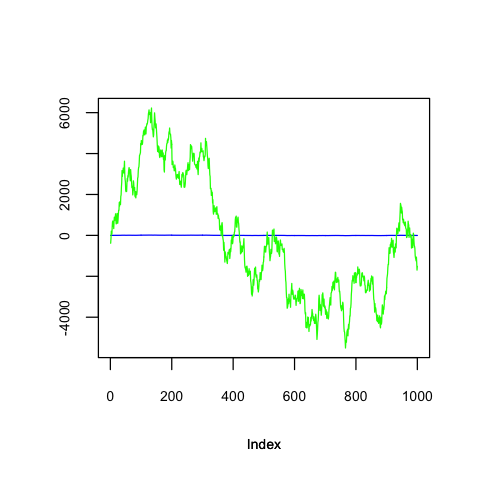

In [11]:
gendata = GenerateData(1000)
par(cex.axis=0.7, cex.lab=0.7, cex.main=0.7, cex.sub=0.7)
plot(gendata$x, type='l', col='blue', ylim=range(gendata$x, gendata$y), ylab='')
par(new=T); plot(gendata$y, type='l', col='green', axes=F, ylab=''); par(new=F)
gendata[names(gendata)=='cointegrated']

And let's try the Bayesian routine to see if the result matches the truth given above when generating

In [12]:
BF <- BayesianLearningTest(gendata$x,gendata$y)
test_result <- BF<0
if (test_result == gendata$cointegrated) {
    comparison <- "Congratulations! The result of the routine matches the ground truth"
} else {
    comparison <- "Unfortunately the routine disagreed with the ground truth"
}
list("test_result"=test_result, "comparison"=comparison)

$test_result
[1] TRUE

$comparison
[1] "Congratulations! The result of the routine matches the ground truth"

## Comparing with Dickey-Fuller

For comparison purposes we now test for cointegration using the standard test.

In [13]:
require(tseries)
ols <- LinearRegression(gendata$x,gendata$y)
epsilon <- gendata$y-ols$intercept-ols$slope*gendata$x
adf <- adf.test(epsilon, k=1)
pvalue <- adf$p.value
cointegrated_adf <- pvalue<0.05
cointegrated_adf

Loading required package: tseries
Warning message in adf.test(epsilon, k = 1):
“p-value smaller than printed p-value”

[1] TRUE

## ROC curve: Bayesian test versus Dickey Fuller

Both the Bayesian learning test and the Dickey-Fuller test do the job and provide a test statistic which we compare against a threshold. To compare which test is better, we look at the ROC curve, and in particular, the AUC of the ROC. To do that, we repeatedly generate time series and perform both tests, then plot the resulting ROC curve.

In [14]:
T <- 20
experiments <- 5000

cointegratedActual <- logical(length=experiments)
logBF <- double(length=experiments)
pvalue <- double(length=experiments)

for (expr in 1:experiments) {
    gendata <- GenerateData(T)
    cointegratedActual[expr] <- gendata$cointegrated

    #classical test
    ols <- LinearRegression(gendata$x,gendata$y)
    epsilon <- gendata$y-ols$intercept-ols$slope*gendata$x
    suppressWarnings(adf <- adf.test(epsilon, k=1))
    pvalue[expr] <- adf$p.value

    #bayesian test
    logBF[expr] <- BayesianLearningTest(gendata$x,gendata$y)
    if (expr %% (experiments/20) == 0) {
        print(paste("Experiment",expr,"of",experiments))
    }
}

[1] "Experiment 250 of 5000"
[1] "Experiment 500 of 5000"
[1] "Experiment 750 of 5000"
[1] "Experiment 1000 of 5000"
[1] "Experiment 1250 of 5000"
[1] "Experiment 1500 of 5000"
[1] "Experiment 1750 of 5000"
[1] "Experiment 2000 of 5000"
[1] "Experiment 2250 of 5000"
[1] "Experiment 2500 of 5000"
[1] "Experiment 2750 of 5000"
[1] "Experiment 3000 of 5000"
[1] "Experiment 3250 of 5000"
[1] "Experiment 3500 of 5000"
[1] "Experiment 3750 of 5000"
[1] "Experiment 4000 of 5000"
[1] "Experiment 4250 of 5000"
[1] "Experiment 4500 of 5000"
[1] "Experiment 4750 of 5000"
[1] "Experiment 5000 of 5000"


Loading required package: pROC
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



$adf

Call:
roc.default(response = cointegratedActual, predictor = -pvalue)

Data: -pvalue in 2539 controls (cointegratedActual FALSE) < 2461 cases (cointegratedActual TRUE).
Area under the curve: 0.7822

$bayes

Call:
roc.default(response = cointegratedActual, predictor = -logBF)

Data: -logBF in 2539 controls (cointegratedActual FALSE) < 2461 cases (cointegratedActual TRUE).
Area under the curve: 0.8976


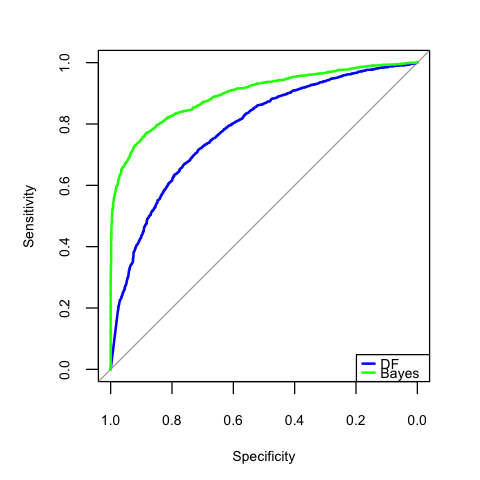

In [15]:
require(pROC)
roc_adf <- roc(cointegratedActual, -pvalue)
roc_bayes <- roc(cointegratedActual, -logBF)
par(cex.axis=0.7, cex.lab=0.7, cex.main=0.7, cex.sub=0.7)
plot.roc(roc_adf, col='blue')
plot.roc(roc_bayes, add=TRUE, col='green')
legend("bottomright", legend=c("DF", "Bayes"),
       col=c("blue",'green'), lwd=2, text.width = 0.15, cex=0.7)
list("adf"=roc_adf, "bayes"=roc_bayes)

The above curve shows the efficacy of the classification of the test between cointegrated and non-cointegrated. Perfect classification occurs in the top left of the chart.

<a class="typeform-share button" href="https://bayesiancointegration.typeform.com/to/gRS0pq" data-mode="popup" style="display:inline-block;text-decoration:none;background-color:#267DDD;color:white;cursor:pointer;font-family:Helvetica,Arial,sans-serif;font-size:20px;line-height:50px;text-align:center;margin:0;height:50px;padding:0px 33px;border-radius:25px;max-width:100%;white-space:nowrap;overflow:hidden;text-overflow:ellipsis;font-weight:bold;-webkit-font-smoothing:antialiased;-moz-osx-font-smoothing:grayscale;" target="_blank">Contact me</a><script>(function(){var qs,js,q,s,d=document,gi=d.getElementById,ce=d.createElement,gt=d.getElementsByTagName,id="typef_orm_share",b="https://s3-eu-west-1.amazonaws.com/share.typeform.com/";if(!gi.call(d,id)){js=ce.call(d,"script");js.id=id;js.src=b+"share.js";q=gt.call(d,"script")[0];q.parentNode.insertBefore(js,q)}})()</script>